# DM-47382: AOS analysis with available databases 


## Versions:

**lsst_distrib** w_2024_43 

Last run: 2024-11-04

## Setup:

This notebook was run on https://usdf-rsp.slac.stanford.edu/ .  The only necessary step required to access `consDB` is to remove the `HTTP_PROXY` environmental variable if present, with eg. `del os.environ["http_proxy"]`.

The Engineering Facilities Database, or EFD, contains fine-grained telemetry from a variety of sensors and instruments, such as 
force balance offsets (hardpoint correction), applied forces (sum of all above + AOS closed-loop corrections). For example [this movie](https://rubin-obs.slack.com/archives/C07QM715AJY/p1718056301907499) was prepared with the EFD data by C. Lage. 


ConsDB generally contains exposure-level  aggregate information, i.e. either information already present in the header of each exposure,  or  in the "Transformed EFD" portion of the ConsDB,  the aggregate  of the time-series EFD data over the exposure time window with the ["EFD Transformation service".](https://rubin-obs.slack.com/archives/C07QJMQ7L4A/p1716317310421029?thread_ts=1716315549.132149&cid=C07QJMQ7L4A)  

In [95]:
from astropy.time import Time, TimeDelta
import pandas as pd
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst.daf import butler as dafButler
import lsst.summit.utils.butlerUtils as butlerUtils
from lsst.summit.utils import ConsDbClient
from lsst.summit.utils.utils import computeCcdExposureId

## Resources on consDB 

* A grafana page with up-to-date [consDB status](https://grafana.slac.stanford.edu/d/z7FCA4Nnk/cloud-native-postgresql-cnpg?orgId=1&refresh=30s&var-DataSource=940RXge4k&var-vcluster=vcluster--usdf-summitdb&var-cluster=summit-db-replica&var-instances=All&var-namespace=summit-db-replica&var-resolution=5m&from=now-24h&to=now)

* Confluence page with documentation on [consDB access](https://rubinobs.atlassian.net/wiki/spaces/~ktl/pages/55377993/ConsDB+Usage) 

* [Schema browser](https://sdm-schemas.lsst.io/) 

* Tech-note on the [background for consDB](https://dmtn-227.lsst.io/) 

* [ConsDB transformed EFD topics](https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48836130/Consolidated+Database+Transformed+EFD+Topics)



## Connecting to consolidated database (consDB)

In [96]:
import os 
del os.environ["http_proxy"]

In [97]:
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
print(f'schemas:\n', client.schema())

schemas:
 ['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim']


In [98]:
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
print(client.schema())  # list the instruments
print(client.schema('lsstcomcam'))  # list tables for an instrument

['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim']
['cdb_lsstcomcam.exposure', 'cdb_lsstcomcam.ccdexposure', 'cdb_lsstcomcam.ccdvisit1_quicklook', 'cdb_lsstcomcam.ccdexposure_flexdata', 'cdb_lsstcomcam.ccdexposure_flexdata_schema', 'cdb_lsstcomcam.ccdexposure_camera', 'cdb_lsstcomcam.exposure_flexdata', 'cdb_lsstcomcam.exposure_flexdata_schema', 'cdb_lsstcomcam.visit1_quicklook']


In [99]:
print(client.schema('lsstcomcam', 'cdb_lsstcomcam.ccdexposure_camera'))

{'ccdexposure_id': ('BIGINT', 'None'), 'temp_set': ('DOUBLE PRECISION', 'None'), 'ccd_temp': ('DOUBLE PRECISION', 'None')}


In [100]:
schema = 'lsstcomcam'
table = 'exposure'
print(f'columns (table={table}): {table} \n',
      list(client.schema('lsstcomcam', f'cdb_{schema}.{table}').keys()
          )
      )

columns (table=exposure): exposure 
 ['exposure_id', 'exposure_name', 'controller', 'day_obs', 'seq_num', 'physical_filter', 'band', 's_ra', 's_dec', 'sky_rotation', 'azimuth_start', 'azimuth_end', 'azimuth', 'altitude_start', 'altitude_end', 'altitude', 'zenith_distance_start', 'zenith_distance_end', 'zenith_distance', 'airmass', 'exp_midpt', 'exp_midpt_mjd', 'obs_start', 'obs_start_mjd', 'obs_end', 'obs_end_mjd', 'exp_time', 'shut_time', 'dark_time', 'group_id', 'cur_index', 'max_index', 'img_type', 'emulated', 'science_program', 'observation_reason', 'target_name', 'air_temp', 'pressure', 'humidity', 'wind_speed', 'wind_dir', 'dimm_seeing', 'focus_z', 'simulated', 's_region', 'vignette', 'vignette_min']


In [101]:
# https://rubin-obs.slack.com/archives/C07QJMQ7L4A/p1730392968242269?thread_ts=1730385376.310139&cid=C07QJMQ7L4A
# For investigating schema and table content 
client = ConsDbClient('http://consdb-pq.consdb:8080/consdb')
schema = 'lsstcomcam'
table = 'ccdvisit1_quicklook'
print(f'schemas:\n', client.schema())  # list the instruments
print(f'tables (schema={schema}):\n', client.schema(schema))  # list tables for an instrument
print(f'columns (table={table}): {table}\n', list(client.schema('lsstcomcam', f'cdb_{schema}.{table}').keys()))

schemas:
 ['latiss', 'lsstcam', 'lsstcamsim', 'lsstcomcam', 'lsstcomcamsim']
tables (schema=lsstcomcam):
 ['cdb_lsstcomcam.exposure', 'cdb_lsstcomcam.ccdexposure', 'cdb_lsstcomcam.ccdvisit1_quicklook', 'cdb_lsstcomcam.ccdexposure_flexdata', 'cdb_lsstcomcam.ccdexposure_flexdata_schema', 'cdb_lsstcomcam.ccdexposure_camera', 'cdb_lsstcomcam.exposure_flexdata', 'cdb_lsstcomcam.exposure_flexdata_schema', 'cdb_lsstcomcam.visit1_quicklook']
columns (table=ccdvisit1_quicklook): ccdvisit1_quicklook
 ['ccdvisit_id', 's_ra', 's_dec', 'zenith_distance', 'photometric_calib', 'psf_sigma', 'sky_bg', 'sky_noise', 'zero_point', 'seeing_zenith_500nm', 'astrom_offset_mean', 'astrom_offset_std', 'eff_time', 'eff_time_psf_sigma_scale', 'eff_time_sky_bg_scale', 'eff_time_zero_point_scale', 'mean_var', 'n_psf_star', 'psf_area', 'psf_ixx', 'psf_ixy', 'psf_iyy', 'psf_star_delta_e1_median', 'psf_star_delta_e2_median', 'psf_star_delta_e1_scatter', 'psf_star_delta_e2_scatter', 'psf_star_delta_size_median', 'psf_s

In [102]:
day_obs = 20241025
query = f"""
SELECT e.band, e.exp_time, q.* 
from cdb_lsstcomcam.visit1_quicklook q, cdb_lsstcomcam.exposure e
where q.visit_id = e.exposure_id
and e.day_obs = {day_obs}
--order by e.seq_num desc
"""
df = client.query(query)
#df.columns
#df[['visit_id', 'eff_time_median', 'eff_time_sky_bg_scale_median', 'eff_time_psf_sigma_scale_median', 'eff_time_zero_point_scale_median']]
df[['visit_id', 'band', 'psf_sigma_median', 'sky_bg_median', 'zero_point_median']][:5]

visit_id,band,psf_sigma_median,sky_bg_median,zero_point_median
int64,str1,float64,float64,object
2024102500091,r,4.391088008880615,1098.607177734375,None
2024102500075,r,4.7036871910095215,380.6881103515625,None
2024102500052,r,4.916060447692871,425.03375244140625,None
2024102500106,r,3.8994481563568115,371.5401306152344,None
2024102500051,r,4.642016887664795,424.9696350097656,None


In [104]:
day_obs = 20241025
query = f"""
SELECT v.band, v.exp_time, q.*
from cdb_lsstcomcam.visit1_quicklook q, cdb_lsstcomcam.visit1 v
where q.visit_id = v.visit_id
and v.day_obs = {day_obs}
"""
df = client.query(query)
df[:5]

band,exp_time,visit_id,n_inputs,astrom_offset_mean_min,astrom_offset_mean_max,astrom_offset_mean_median,astrom_offset_std_min,astrom_offset_std_max,astrom_offset_std_median,eff_time_min,eff_time_max,eff_time_median,eff_time_psf_sigma_scale_min,eff_time_psf_sigma_scale_max,eff_time_psf_sigma_scale_median,eff_time_sky_bg_scale_min,eff_time_sky_bg_scale_max,eff_time_sky_bg_scale_median,eff_time_zero_point_scale_min,eff_time_zero_point_scale_max,eff_time_zero_point_scale_median,max_dist_to_nearest_psf_min,max_dist_to_nearest_psf_max,max_dist_to_nearest_psf_median,mean_var_min,mean_var_max,mean_var_median,n_psf_star_min,n_psf_star_max,n_psf_star_median,n_psf_star_total,psf_area_min,psf_area_max,psf_area_median,psf_ixx_min,psf_ixx_max,psf_ixx_median,psf_ixy_min,psf_ixy_max,psf_ixy_median,psf_iyy_min,psf_iyy_max,psf_iyy_median,psf_sigma_min,psf_sigma_max,psf_sigma_median,psf_star_delta_e1_median_min,psf_star_delta_e1_median_max,psf_star_delta_e1_median_median,psf_star_delta_e1_scatter_min,psf_star_delta_e1_scatter_max,psf_star_delta_e1_scatter_median,psf_star_delta_e2_median_min,psf_star_delta_e2_median_max,psf_star_delta_e2_median_median,psf_star_delta_e2_scatter_min,psf_star_delta_e2_scatter_max,psf_star_delta_e2_scatter_median,psf_star_delta_size_median_min,psf_star_delta_size_median_max,psf_star_delta_size_median_median,psf_star_delta_size_scatter_min,psf_star_delta_size_scatter_max,psf_star_delta_size_scatter_median,psf_star_scaled_delta_size_scatter_min,psf_star_scaled_delta_size_scatter_max,psf_star_scaled_delta_size_scatter_median,psf_trace_radius_delta_min,psf_trace_radius_delta_max,psf_trace_radius_delta_median,sky_bg_min,sky_bg_max,sky_bg_median,sky_noise_min,sky_noise_max,sky_noise_median,seeing_zenith_500nm_min,seeing_zenith_500nm_max,seeing_zenith_500nm_median,zero_point_min,zero_point_max,zero_point_median,low_snr_source_count_min,low_snr_source_count_max,low_snr_source_count_median,low_snr_source_count_total,high_snr_source_count_min,high_snr_source_count_max,high_snr_source_count_median,high_snr_source_count_total,day_obs,seq_num,postisr_pixel_median_median,postisr_pixel_median_mean,postisr_pixel_median_max
str1,float64,int64,int64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,int64,int64,object,object,object
r,30.0,2024102500091,5,0.07293230295181274,0.07293230295181274,0.07293230295181274,0.034995079040527344,0.034995079040527344,0.034995079040527344,None,None,None,0.051862768828868866,0.051862768828868866,0.051862768828868866,0.027307303622364998,0.027307303622364998,0.027307303622364998,None,None,None,1214.4112548828125,1214.4112548828125,1214.4112548828125,1205.3809814453125,1205.3809814453125,1205.3809814453125,36,36,36,180,250.20120239257812,250.20120239257812,250.20120239257812,14.73707103729248,14.73707103729248,14.73707103729248,10.457147598266602,10.457147598266602,10.457147598266602,32.73714828491211,32.73714828491211,32.73714828491211,4.391088008880615,4.391088008880615,4.391088008880615,-0.010904110968112946,-0.010904110968112946,-0.010904110968112946,0.010829177685081959,0.010829177685081959,0.010829177685081959,0.009272882714867592,0.009272882714867592,0.009272882714867592,0.009091529063880444,0.009091529063880444,0.009091529063880444,0.08107155561447144,0.08107155561447144,0.08107155561447144,0.040845680981874466,0.040845680981874466,0.040845680981874466,0.008421012200415134,0.008421012200415134,0.008421012200415134,0.4

## Resources on EFD

* [EFD documentation](https://sasquatch.lsst.io/user-guide/observatorytelemetry.html)
* [Query examples](https://github.com/lsst-sqre/system-test/tree/main/efd_examples)
* [Documentation for the python connection client](https://efd-client.lsst.io/api.html)


## Connecting to EFD 

In [9]:
butler = dafButler.Butler('/repo/embargo_new', 
                          collections=["LSSTComCam/raw/all", 
                                       "LSSTComCam/calib", 
                                       "LSSTComCam/nightlyValidation"
                                                           ]
                         )
client = makeEfdClient()

Given eg. RubinTV, we can find two defocal pairs to query EFD for the time corresponding to just before the first exposure, and just after the last exposure. For instance, on  `20241030` seq_num `72` and `73`. One way to get the time spans is to query the registry, and look at `min`, `max` values of `dataId.exposure.timespan`

In [36]:
dataRefs = list(butler.registry.queryDatasets('postISRCCD', where="instrument='LSSTComCam' and \
exposure.observation_type='cwfs' and day_obs = 20241030 and exposure.seq_num in (72,73)").expanded())

Or we can use the `butlerUtils` package to obtain the exposure record (including timespan) for the first and last seqNum:

In [41]:
expId = 2024103000072
dataId = {'exposure': expId, 'detector': 4, 'instrument': 'LSSTComCam'}
expRecordBegin = butlerUtils.getExpRecordFromDataId(butler, dataId)

In [45]:
expId = 2024103000073
dataId = {'exposure': expId, 'detector': 4, 'instrument': 'LSSTComCam'}
expRecordEnd = butlerUtils.getExpRecordFromDataId(butler, dataId)

In [47]:
expRecordBegin.timespan.begin

<Time object: scale='tai' format='jd' value=2460614.557400162>

In [48]:
expRecordEnd.timespan.end

<Time object: scale='tai' format='jd' value=2460614.5582553586>

In [52]:
td = expRecordEnd.timespan.end-expRecordBegin.timespan.begin
print('Time it took to take two exposures:', td.sec, ' sec') 

Time it took to take two exposures: 73.88901476899967  sec


Which makes sense with 30 sec exposure time. 

A list of EFD topics is available 

In [71]:
topics = await client.get_topics()
len(topics)

2793

A huge number of topics is available, and those that start with `lsst.sal` are most pertinent:

In [72]:
# from https://rubin-obs.slack.com/files/U07D8TLA3C3/F07QJPNTUE7/searching_the_efd
tt = [t.split('.') for t in topics]
topic_dict = {}
for t in tt:
    i = 0
    dd = topic_dict
    while i < len(t):
        if t[i] not in dd.keys():
            dd[t[i]] = {}
        dd = dd[t[i]]
        i += 1

# useful topics are 'lsst.sal.X' 
print(list(topic_dict['lsst']['sal'].keys()))

['ATAOS', 'ATArchiver', 'ATCamera', 'ATDome', 'ATDomeTrajectory', 'ATHeaderService', 'ATHexapod', 'ATMCS', 'ATMonochromator', 'ATOODS', 'ATPneumatics', 'ATPtg', 'ATSpectrograph', 'ATWhiteLight', 'AdamSensors', 'CBP', 'CCArchiver', 'CCCamera', 'CCHeaderService', 'CCOODS', 'DIMM', 'DSM', 'Dome', 'EPM', 'ESS', 'Electrometer', 'Environment', 'FiberSpectrograph', 'GCHeaderService', 'GIS', 'GenericCamera', 'HVAC', 'Hexapod', 'LaserTracker', 'MTAOS', 'MTAirCompressor', 'MTCamera', 'MTDome', 'MTDomeTrajectory', 'MTHeaderService', 'MTHexapod', 'MTM1M3', 'MTM1M3TS', 'MTM2', 'MTMount', 'MTOODS', 'MTPtg', 'MTRotator', 'MTVMS', 'NewMTMount', 'OCPS', 'PMD', 'Rotator', 'Scheduler', 'Script', 'ScriptQueue', 'Test', 'TunableLaser', 'Watcher', 'WeatherForecast', 'WeatherStation']


In [ ]:
# Pick a CSC and see more about its topics
ss = 'MTAOS'
for tt in topic_dict['lsst']['sal'][ss].keys():
    topic = f'lsst.sal.{ss}.{tt}'
    print(topic)
    try:
        fields = await client.get_fields(topic)
    except: 
        fields  = ['value']
    fields = [f for f in fields if ('private' not in f) and (f != 'name') and (f != 'duration')]
    try:
        dd = await client.select_top_n(topic, fields, 1)
    except: 
        print('query failed')
    display(dd)    
	

An example used in Craig's [notebook](https://rubin-obs.slack.com/files/U07NQHE622U/F07UYPV2XDY/comcam_get_aos_for_exposure_05nov24.ipynb)  employs `lsst.sal.MtM1M3.appliedForces` and `lsst.sal.MTHexapod.application`. We can query these topics within the specified time:

In [55]:
t1 = expRecordBegin.timespan.begin.utc
t2 = expRecordEnd.timespan.end.utc
end_readout = await client.select_time_series("lsst.sal.MTM1M3.appliedForces", '*',t1, t2)


In [56]:
end_readout[:5]

,forceMagnitude,fx,fy,fz,mx,my,mz,private_efdStamp,private_identity,private_kafkaStamp,...,zForces90,zForces91,zForces92,zForces93,zForces94,zForces95,zForces96,zForces97,zForces98,zForces99
2024-10-31 01:22:02.393279+00:00,172921.671875,58.114883,67340.632812,159270.656250,694.933838,-650.493774,-971.494141,1.730338e+09,MTM1M3,1.730338e+09,...,1304.410156,958.630005,972.061462,1023.968323,1112.090942,1201.591675,422.335266,1085.480591,1063.119873,1056.121704
2024-10-31 01:22:02.413380+00:00,172919.328125,58.035782,67335.523438,159270.265625,683.036865,-674.005615,-964.942810,1.730338e+09,MTM1M3,1.730338e+09,...,1304.411865,958.624084,971.995117,1023.867859,1111.980591,1201.466797,422.257629,1085.394287,1063.018311,1056.026123
2024-10-31 01:22:02.433308+00:00,172915.750000,57.209473,67335.945312,159266.203125,703.733765,-660.368225,-974.740906,1.730338e+09,MTM1M3,1.730338e+09,...,1304.348022,958.576782,972.027771,1023.930420,1112.034302,1201.526245,422.311981,1085.476929,1063.112549,1056.090576
2024-10-31 01:22:02.453402+00:00,172918.578125,58.228699,67339.093750,159267.953125,677.326050,-650.000916,-965.161377,1.730338e+09,MTM1M3,1.730338e+09,...,1304.416870,958.646362,972.018616,1023.906982,1112.044556,1201.546265,422.334808,1085.368286,1063.011719,1056.055908
2024-10-31 01:22:02.473394+00:00,172918.421875,58.730286,67345.023438,159265.265625,667.223511,-663.067505,-962.951599,1.730338e+09,MTM1M3,1.730338e+09,...,1304.433350,958.656006,971.975830,1023.837280,1111.964966,1201.445679,422.263397,1085.311768,1062.939941,1055.985352


In [62]:
hexData = await client.select_time_series("lsst.sal.MTHexapod.application", '*',t1,t2)
print(len(hexData))

2955


In [58]:
hexData[:5]

,demand0,demand1,demand2,demand3,demand4,demand5,error0,error1,error2,error3,...,position5,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,salIndex
2024-10-31 01:22:02.396101+00:00,-0.719819,-140.033914,-965.445758,-0.003953,0,0,-0.519611,-0.663470,-0.218053,-0.000012,...,0.000005,1.730338e+09,MTHexapod:1,1.730338e+09,1995381,1.730338e+09,5601ef5d,1313740,1.730338e+09,1
2024-10-31 01:22:02.407415+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.047294,-0.656576,-0.372867,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312405,1.730338e+09,2
2024-10-31 01:22:02.436151+00:00,-0.719819,-140.033914,-965.445758,-0.003953,0,0,-0.516147,-0.650306,-0.219127,-0.000012,...,0.000005,1.730338e+09,MTHexapod:1,1.730338e+09,1995381,1.730338e+09,5601ef5d,1313741,1.730338e+09,1
2024-10-31 01:22:02.447609+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.046070,-0.657750,-0.373522,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312406,1.730338e+09,2
2024-10-31 01:22:02.496381+00:00,-0.719819,-140.033914,-965.445758,-0.003953,0,0,-0.508070,-0.646379,-0.218714,-0.000012,...,0.000006,1.730338e+09,MTHexapod:1,1.730338e+09,1995381,1.730338e+09,5601ef5d,1313742,1.730338e+09,1


In [63]:
m2Hex = hexData[hexData['salIndex'] == 2]
print(len(m2Hex))

1477


In [61]:
m2Hex[:5]

,demand0,demand1,demand2,demand3,demand4,demand5,error0,error1,error2,error3,...,position5,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,salIndex
2024-10-31 01:22:02.407415+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.047294,-0.656576,-0.372867,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312405,1.730338e+09,2
2024-10-31 01:22:02.447609+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.046070,-0.657750,-0.373522,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312406,1.730338e+09,2
2024-10-31 01:22:02.507751+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.047911,-0.654890,-0.373540,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312407,1.730338e+09,2
2024-10-31 01:22:02.547922+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.048985,-0.655695,-0.374470,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312408,1.730338e+09,2
2024-10-31 01:22:02.607941+00:00,1001.529979,94.248818,251.859181,-0.001514,0,0,0.049335,-0.654483,-0.373850,0.000002,...,-0.000007,1.730338e+09,MTHexapod:2,1.730338e+09,1997339,1.730338e+09,5601ef5d,1312409,1.730338e+09,2


In [21]:
m2Hex.columns

Index(['demand0', 'demand1', 'demand2', 'demand3', 'demand4', 'demand5',
       'error0', 'error1', 'error2', 'error3', 'error4', 'error5', 'position0',
       'position1', 'position2', 'position3', 'position4', 'position5',
       'private_efdStamp', 'private_identity', 'private_kafkaStamp',
       'private_origin', 'private_rcvStamp', 'private_revCode',
       'private_seqNum', 'private_sndStamp', 'salIndex'],
      dtype='object')

Plot the x,y,z position as a function of time : 

In [64]:
X = m2Hex["position0"]
Y = m2Hex["position1"]
Z = m2Hex["position2"]
time = m2Hex.index

Text(0.5, 1.0, 'MT hexapod position, exposures 2024103000072 and 2024103000072')

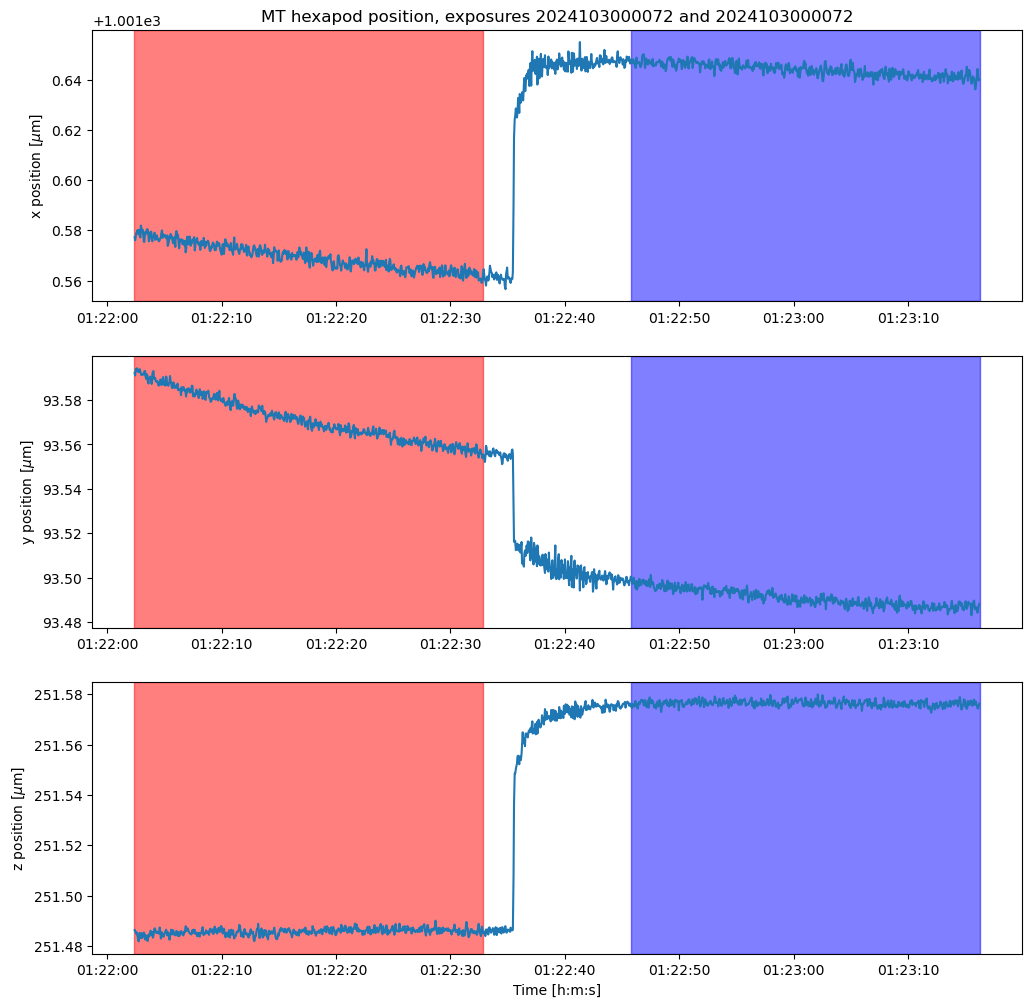

In [93]:
import matplotlib.pyplot as plt 
fig,ax = plt.subplots(3,1,figsize=(12,12))
i = 0 
for pos, name in zip([X,Y,Z], 'xyz'):
    ax[i].plot(time, pos, )
    ax[i].set_ylabel(f'{name} position '+r'[$\mu $m]')
    
    ax[i].axvspan(expRecordBegin.timespan.begin.utc.datetime, 
               expRecordBegin.timespan.end.utc.datetime, 
               alpha=0.5, color='red')

    ax[i].axvspan(expRecordEnd.timespan.begin.utc.datetime, 
               expRecordEnd.timespan.end.utc.datetime, 
               alpha=0.5, color='blue')


    
    i += 1 
ax[-1].set_xlabel('Time [h:m:s]')
ax[0].set_title(f'MT hexapod position, exposures {expRecordBegin.id} and {expRecordBegin.id}')

The two filled rectangles mark the integration time of the two considered  exposures.